![](https://i.ibb.co/7pC1Y9q/lungs.jpg)

<p style='text-align: right;'><span style="color: #000508; font-family: Segoe UI; font-size: 0.7em; font-weight: 300;">Image Source: www.nhlbi.nih.gov</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">SIIM COVID-19 Resize & Process + Coco Dataset</span></p>

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Overview</span>

<p style='text-align: justify;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">This notebook covers the following:</span></p>

- Read Dicom Images
- Resize and Save to PNG
- Generate Metadata for Train and Test Datasets
- Process and Resize Bounding Boxes
- Visualise Images
- GroupKFold Train-Val Split
- Generate GroupKFold COCO Dataset


<p style='text-align: justify;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">The resized images and the COCO Annotations are registered as datasets:</span></p>


**SIIM covid19 512 images and metadata**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-512-images-and-metadata

**SIIM Covid-19 COCO 512x512 GroupKFold**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-coco-512x512-groupkfold

I will update these datasets if needed, when the issues in the discussions regarding the dataset are resolved by the organizers.


### References

- https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
- https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
- https://www.kaggle.com/sreevishnudamodaran/vinbigdata-fusing-bboxes-coco-dataset

<br>

<a href="https://www.kaggle.com/sreevishnudamodaran"><center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Ask%20me-something-1abc9c.svg?style=flat-square&logo=kaggle" width="130" height="10"></center></a>

<center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Please-Upvote%20If%20you%20like%20this-07b3c8?style=for-the-badge&logo=kaggle" width="260" height="20"></center>

In [ ]:
# !conda install gdcm -c conda-forge -y

In [1]:
import os
import ast
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import glob
import json

from PIL import Image
from tqdm.auto import tqdm
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from fastai.medical.imaging import *

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Read Dicom Images and  Resize and Save to PNG</span>

In [2]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(dicom, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    # dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)    
    
    return data

In [3]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

In [4]:
size_patch = 512

path_dicom = Path('/host_Data/DataSets/Kaggle-SIIM Covid 19/siim-covid19-detection')
path_output_patches = path_dicom / ('DS-COCO_' + str(size_patch))
labels_dcm_image = 'train_image_level.csv'
labels_dcm_study = 'train_study_level.csv'

In [5]:
items = get_dicom_files(path_dicom /f'train/')

for item in items[:3]:
    dcm = item.dcmread()
    dcm_np = dcm.pixel_array
    print(dcm_np.shape)


(2330, 2783)
(3093, 2850)
(2539, 3050)


In [6]:
new_size = size_patch

for split in ['train', 'test']:
# for split in ['test']:
    save_dir = path_output_patches / f'{split}/'
    os.makedirs(save_dir, exist_ok=True)

    image_ids = []
    folder_ids = []
    study_ids = []
    widths = []
    heights = []

    dicoms = get_dicom_files(path_dicom / split)

    print('Count of Dicom Files=', len(dicoms))

    for item in tqdm(dicoms[:100]):
        path = str(item)
        dicom = item.dcmread()
        
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(dicom)
        im = resize(xray, size=new_size)
        
        path_split = path.split('/')
        study_id = path_split[-3]
        folder_id = path_split[-2]
        image_name = path_split[-1].replace('.dcm', '_image')
        
        im.save(os.path.join(save_dir, image_name+'.png'))
        
        image_ids.append(image_name)
        folder_ids.append(folder_id)
        study_ids.append(study_id)
        widths.append(xray.shape[0])
        heights.append(xray.shape[1])
    
    df = pd.DataFrame.from_dict({'id': image_ids, 'folder_id': folder_ids,
                                 'study_id': study_ids, 'width': widths,
                                 'height': heights})
    df.to_csv(path_output_patches / f'{split}_meta.csv', index=False)

Count of Dicom Files= 6334


  0%|          | 0/100 [00:00<?, ?it/s]

Count of Dicom Files= 1263


  0%|          | 0/100 [00:00<?, ?it/s]

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Process and Resize Bounding Boxes</span>

In [7]:
df_train = pd.read_csv(path_dicom / "train_image_level.csv")
df_train.head(3)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7


In [8]:
df_train_meta = pd.read_csv(path_output_patches / "train_meta.csv")
df_train_meta.head(3)

,id,folder_id,study_id,width,height
0,65761e66de9f_image,9e8302230c91,00086460a852,2330,2783
1,51759b5579bc_image,e555410bd2cd,000c9c05fd14,3093,2850
2,f6293b1c49e2_image,73120b4a13cb,00292f8c37bd,2539,3050


In [9]:
df_train = df_train.merge(df_train_meta, on='id')
df_train.head(3)

,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height
0,0060e4f54aa8_image,"[{'x': 491.36972, 'y': 1036.73739, 'width': 491.36972, 'height': 1049.42517}, {'x': 2642.86715, 'y': 1152.56026, 'width': 603.68286, 'height': 1038.896}]",opacity 1 491.36972 1036.73739 982.73944 2086.1625599999998 opacity 1 2642.86715 1152.56026 3246.55001 2191.45626,02e31620e4e7,fb593f9b0d03,02e31620e4e7,2800,3408
1,00e37a390f0f_image,"[{'x': 511.60646, 'y': 285.22763, 'width': 472.49829, 'height': 1578.83585}, {'x': 2173.99377, 'y': 331.32503, 'width': 800.94238, 'height': 1371.39749}]",opacity 1 511.60646 285.22763 984.10475 1864.0634799999998 opacity 1 2173.99377 331.32503 2974.93615 1702.72252,02f88d67e4d6,0665e81b7b4a,02f88d67e4d6,2544,3056
2,085d6edba7cb_image,NaN,none 1 0 0 1 1,02accd5bab1f,9e1743d0e501,02accd5bab1f,2290,2800


In [10]:
## Drop all rows of images without annotations
df_train = df_train.dropna()

imagepaths = df_train.id.unique()
print("Number of Images with Covid_Abnormality:",len(imagepaths))

Number of Images with Covid_Abnormality: 58


### Adding Rows for Each Bounding Box

In [11]:
new_size = (size_patch, size_patch)
df_idx=0

for idx, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    img = cv2.imread(os.path.join("train",
                                  row.id.replace("_image", ".png")))
    bboxes = [list(bbox.values()) for bbox in ast.literal_eval(row.boxes)]
    height_ratio, width_ratio = (new_size[0]/row.height, new_size[1]/row.width)
    
    for box in bboxes:
        box[2] = box[2]+box[0]
        box[3] = box[3]+box[1]
        box = (box[0]*height_ratio, box[1]*width_ratio,
               box[2]*height_ratio, box[3]*width_ratio)
        
        row_df = pd.DataFrame({'id':row.id,
                       'StudyInstanceUID':row.StudyInstanceUID,
                       'folder_id':row.folder_id,
                       'study_id':row.study_id,
                       'width':row.width,
                       'height':row.height,
                       'xmin':round(box[0]),
                       'ymin':round(box[1]),
                       'xmax':round(box[2]),
                       'ymax':round(box[3])}, index=[df_idx])

        if df_idx==0:
            df_train_processed = row_df
        else:
            df_train_processed = pd.concat([df_train_processed, row_df])
        
        df_idx+=1
        
df_train_processed.head(3)

  0%|          | 0/58 [00:00<?, ?it/s]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax
0,0060e4f54aa8_image,02e31620e4e7,fb593f9b0d03,02e31620e4e7,2800,3408,74,190,148,381
1,0060e4f54aa8_image,02e31620e4e7,fb593f9b0d03,02e31620e4e7,2800,3408,397,211,488,401
2,00e37a390f0f_image,02f88d67e4d6,0665e81b7b4a,02f88d67e4d6,2544,3056,86,57,165,375


In [12]:
df_train_processed.to_csv(path_output_patches / "df_train_processed_meta.csv", index=False)
df_train_processed.shape

(109, 10)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Visualise Images</span>

In [13]:
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.6
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

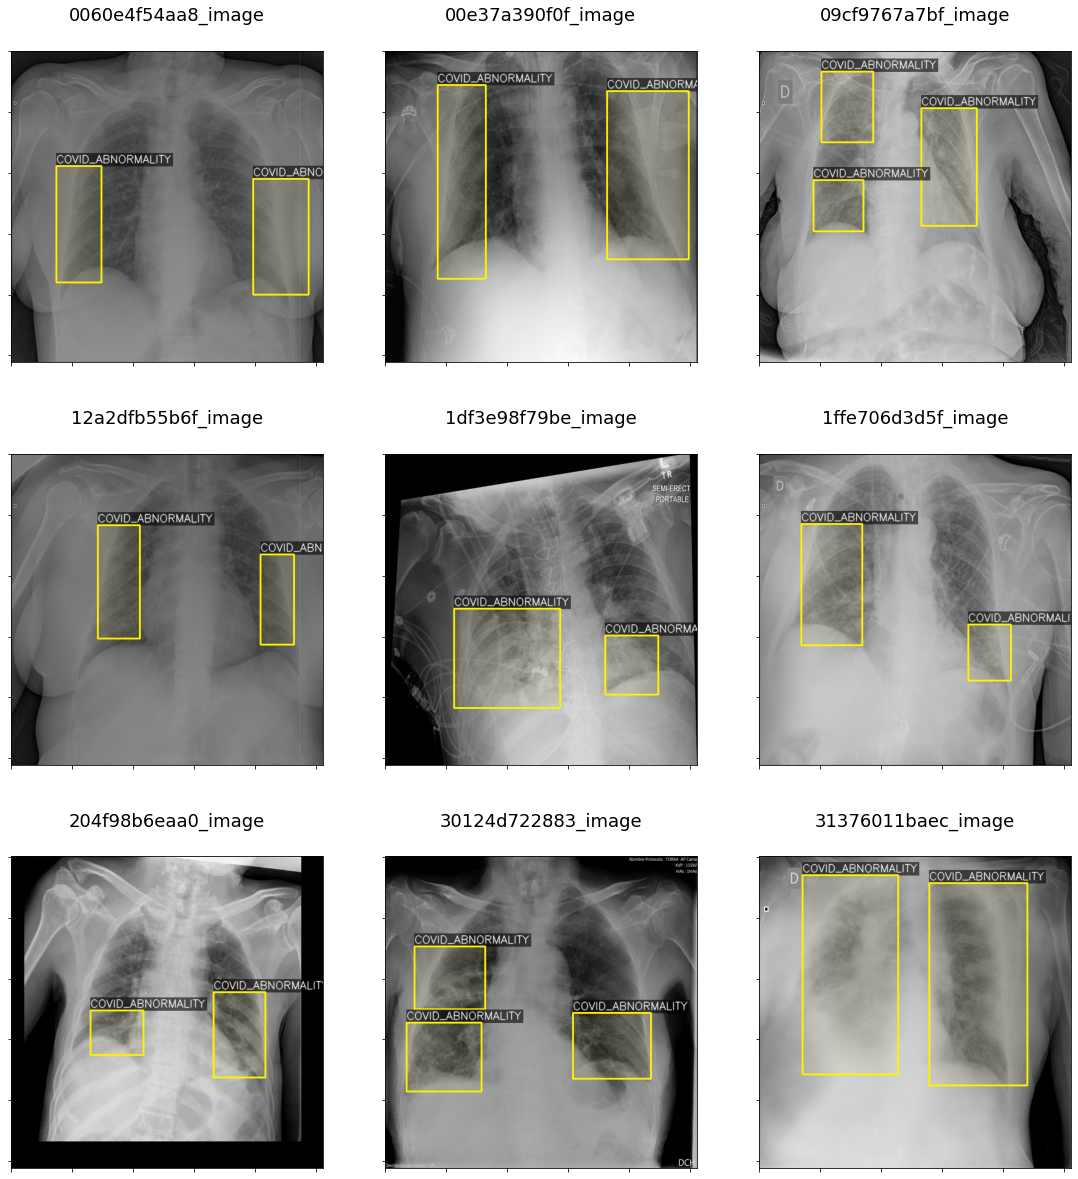

In [14]:
new_size = (size_patch, size_patch)
imgs_path = path_output_patches / "train"

fig, axes = plt.subplots(3,3, figsize=(19,21))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.ravel()
pos = 0

for idx, img_id in enumerate(imagepaths[:9]):
    img = cv2.imread(os.path.join(imgs_path, img_id+".png"))
    img_annotations = df_train_processed[df_train_processed.id==img_id]
    bboxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy().tolist()
    
    for box in bboxes:
        img = draw_bbox(img, list(np.int_(box)), "Covid_Abnormality",
                        (255, 243, 0))

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(img_id, size=18, pad=30)
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])

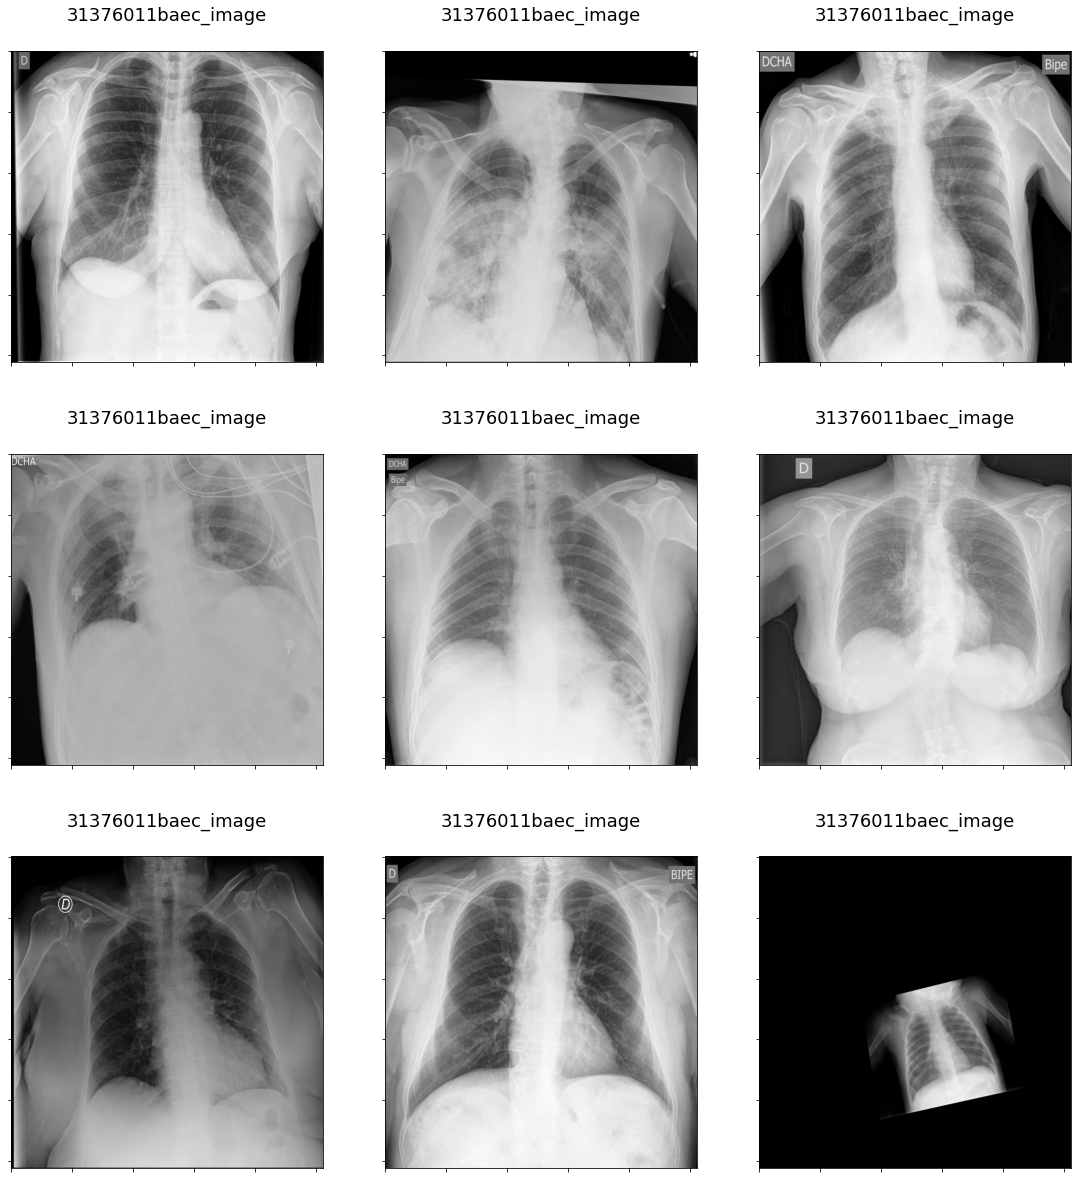

In [15]:
df_test = pd.read_csv(path_output_patches / "test_meta.csv")

fig, axes = plt.subplots(3, 3, figsize=(19,21))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.ravel()
pos = 0

for idx in df_test.id[:9]:
    img = mpimg.imread(os.path.join(path_output_patches / "test/", idx+'.png'))
    axes[pos].imshow(img, cmap='gray')
    axes[pos].set_title(img_id, size=18, pad=30)
    axes[pos].set_xticklabels([])
    axes[pos].set_yticklabels([])
    pos += 1

In [16]:
# %%time

# Tar Images
# !tar -zcf train.tar.gz -C "/kaggle/tmp/train/" .
# !tar -zcf test.tar.gz -C "/kaggle/tmp/test/" .

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Load Annotations from Dataset</span>


The resized images and the annotations generated above are in this dataset:

**SIIM covid19 512 images and metadata**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-512-images-and-metadata

In [17]:
df_annotations = pd.read_csv(path_output_patches / "df_train_processed_meta.csv")
df_annotations.sample(3)

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax
29,50ce4338c040_image,032ba2202933,00c0d70d6dc9,032ba2202933,2436,3032,308,133,460,357
46,74077a8e3b7c_image,00f9e183938e,89bad86310f9,00f9e183938e,2544,3056,364,226,437,327
45,6fb675554ba4_image,045762d32a15,8a4ddf568efd,045762d32a15,2336,2836,145,210,243,378


<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">GroupKFold Train-Val Split</span>

In [18]:
from sklearn.model_selection import GroupKFold, train_test_split

kfold = 5
df_annotations['fold'] = -1
group_kfold  = GroupKFold(n_splits = kfold)

for fold, (train_index, val_index) in enumerate(group_kfold.split(df_annotations,
                                                              groups=df_annotations.id.tolist())):
    df_annotations.loc[val_index, 'fold'] = fold

In [19]:
val_fold = 0
train_ids = df_annotations[df_annotations['fold'] != fold].id.unique()
val_ids = df_annotations[df_annotations['fold'] == fold].id.unique()

print("Split Counts\nTrain Images:\t\t{0}\nVal Images:\t\t{1}"
      .format(len(train_ids), len(val_ids)))

Split Counts
Train Images:		47
Val Images:		11


<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Generate GroupKFold COCO Dataset</span>

### COCO Format Overview


```python
{
  "type": "instances",
  "images": [
    {
      "file_name": "<image_name.png>",
      "height": "<height>",
      "width": "<width>",
      "id": "<Used to reference each image and it should be unique for each image>"
    }
#    .
#    .
  ],
  "categories": [
    {
      "supercategory": "none",
      "name": "<Class One>",
      "id": 0
    },
#    .
#    .
  ],
  "annotations": [
    {
      "id": 1,
      "bbox": [
        "<xmin>",
        "<ymin>",
        "<bbox-width>",
        "<bbox-height>"
      ],
      "image_id": "<id of the image from which the polygon annotation is from as defined in the 'images' block above>",
      "segmentation": [
          "<x1>",
          "<y1>",
          "<x2>",
          "<y2>"
#          .
#          .
      ],
      "ignore": 0,
      "area": "<Area of the Polygon represented by the points in the 'segmentation' block>",
      "iscrowd": 0,
      "category_id": "<Class category ID as an integer which will be defined below>"
    },
  ],
"categories": [
    {
        "supercategory": null,
        "id": "<Integer ID for the Class Label>",
        "name": "<Class One Label as a String>"
    },
#    .
#    .
]
}
```

In [20]:
now = datetime.datetime.now()

data = dict(
    info=dict(
        description='SIIM Covid-19 GroupKfold',
        url=None,
        version=None,
        year=now.year,
        contributor=None,
        date_created=now.strftime('%Y-%m-%d %H:%M:%S.%f'),
    ),
    licenses=[dict(
        url=None,
        id=0,
        name=None,
    )],
    images=[
        # license, url, file_name, height, width, date_captured, id
    ],
    type='instances',
    annotations=[
        # segmentation, area, iscrowd, image_id, bbox, category_id, id
    ],
    categories=[
        # supercategory, id, name
    ],
)

In [21]:
class_name_to_id = {}

labels =  ["__ignore__",
            "Covid_Abnormality"]

for i, each_label in enumerate(labels):
    class_id = i - 1  # starts with -1
    class_name = each_label
    if class_id == -1:
        assert class_name == '__ignore__'
        continue
    class_name_to_id[class_name] = class_id
    data['categories'].append(dict(
        supercategory=None,
        id=class_id,
        name=class_name,
    ))
    
data

{'info': {'description': 'SIIM Covid-19 GroupKfold',
  'url': None,
  'version': None,
  'year': 2021,
  'contributor': None,
  'date_created': '2021-06-02 07:52:02.982786'},
 'licenses': [{'url': None, 'id': 0, 'name': None}],
 'images': [],
 'type': 'instances',
 'annotations': [],
 'categories': [{'supercategory': None, 'id': 0, 'name': 'Covid_Abnormality'}]}

In [22]:
H, W = (size_patch, size_patch)

# for fold in range(kfold):

train_ids = df_annotations[df_annotations['fold'] != fold].id.unique()
val_ids = df_annotations[df_annotations['fold'] == fold].id.unique()
print(f"\nFold: {fold}\n Train images count: {len(train_ids)}, Val images count: {len(val_ids)}")

## Setting the output annotation json file paths
train_out_file = f'train_annotations_fold{fold}.json'
val_out_file = f'val_annotations_fold{fold}.json'

data_train = data.copy()
data_train['images'] = []
data_train['annotations'] = []
data_val = data.copy()
data_val['images'] = []
data_val['annotations'] = []

for i, img_id in tqdm(enumerate(train_ids), total=len(train_ids)):

    data_train['images'].append(dict(license=0,
                                     url=None,
                                     file_name=img_id+'.png',
                                     height=H,
                                     width=W,
                                     date_captured=None,
                                     id=i
                                    ))

    img_annotations = df_annotations[df_annotations.id==img_id]
    boxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
    box_labels = np.zeros(img_annotations.shape[0])

    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                int(x_min),
                int(y_min),
                int(x_max-x_min),
                int(y_max-y_min)
                ]

        data_train['annotations'].append(dict(id=len(data_train['annotations']),
                                              image_id=i,
                                              category_id=int(label),
                                              area=int(area),
                                              bbox=bbox,
                                              iscrowd=0)) 
with open(path_output_patches / train_out_file, 'w') as f:
    json.dump(data_train, f, indent=4)

for i, img_id in tqdm(enumerate(val_ids), total=len(val_ids)):
    data_val['images'].append(dict(license=0,
                                     url=None,
                                     file_name=img_id+'.png',
                                     height=H,
                                     width=W,
                                     date_captured=None,
                                     id=i
                                    ))

    img_annotations = df_annotations[df_annotations.id==img_id]
    boxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
    box_labels = np.zeros(img_annotations.shape[0])

    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                int(x_min),
                int(y_min),
                int(x_max-x_min),
                int(y_max-y_min)
                ]

        data_val['annotations'].append(dict(id=len(data_val['annotations']),
                                            image_id=i,
                                            category_id=int(label),
                                            area=int(area),
                                            bbox=bbox,
                                            iscrowd=0))             
with open(path_output_patches / val_out_file, 'w') as f:
    json.dump(data_val, f, indent=4)


Fold: 4
 Train images count: 47, Val images count: 11


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.4em; font-weight: 300;">Let me know if you have any suggestions!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">THANKS!</span></p>